# Loading images from the Quick Draw Dataset 5k examples


get the data at https://console.cloud.google.com/storage/browser/quickdraw_dataset/full/numpy_bitmap?pli=1


In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Dense, Dropout, Flatten,Input, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
import keras.backend as K

import tensorflow as tf

import os
import pickle
import numpy as np

In [2]:
print(keras.__version__)
print(tf.__version__)

2.0.8
1.3.0


In [3]:
num_examples_per_class = 5000

classes = ['airplane','alarm clock','ambulance','angel','ant','anvil','apple','axe','banana','bandage','barn','baseball bat','baseball',
           'basket','basketball','bathtub','beach','bear','beard','bed','bee','belt','bicycle','binoculars','birthday cake','blueberry',
           'book','boomerang','bottlecap','bowtie','bracelet','brain','bread','broom','bulldozer','bus','bus','butterfly','cactus','cake',
           'calculator','calendar','camel','camera','campfire','candle','cannon','canoe','car','carrot','cello','computer',
           'cat','chandelier','clock','cloud','coffee cup','compass','cookie','couch','cow','crab','crayon','crocodile','crown',
           'cup','diamond','dog','dolphin','donut','dragon','dresser','drill','drums','duck','dumbbell','ear','elbow',
           'elephant','envelope','eraser','eye','eyeglasses','face','fan','feather','fence','finger','fire hydrant',
           'fireplace','firetruck','fish','flamingo','flashlight','flip flops','floor lamp','flower','flying saucer',
           'foot','fork']

In [4]:
len(classes)

100

## Load the image data from scratch

Only use if you are downloading the raw data and doing it yourself

In [ ]:
#This cell is only if you are loading the data from scratch
# get the data 
quickdraws = [np.load("../../data/{}.npy".format(qdraw))[:num_examples_per_class] for qdraw in classes]

# Concat the arrays together
x_data = np.concatenate(quickdraws,axis=0)

x_data.shape

In [58]:
np.save('x_data_100_classes_5k.npy',x_data)

## Use this cell to load the premade datasets that I made

In [7]:
x_data = np.load("./data/x_data_100_classes_5k.npy")

In [8]:
x_data.shape

(500000, 784)

## Lets make some labels for our data

In [9]:
labels = [np.full((num_examples_per_class,), classes.index(qdraw)) for qdraw in classes]

## Concat the arrays together
y_data = np.concatenate(labels,axis=0)
y_data.shape

(500000,)

## lets look at the Images 

In [10]:
def show_object(obj):
    # Reshape 784 array into 28x28 image
    image = obj.reshape([28,28])
    fig, axes = plt.subplots(1, )
    fig.subplots_adjust(hspace=0.5, wspace=0.5)
    plt.imshow(image, cmap='gray_r')
    plt.show()

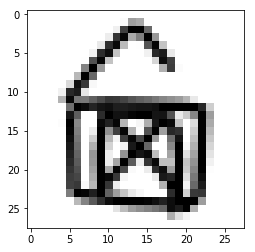

10


In [11]:
show_object(x_data[53000])
print(y_data[53000])

In [12]:
print(x_data.shape)
print(y_data.shape)

(500000, 784)
(500000,)


In [13]:
#shuffling function
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [14]:
x_data,y_data = unison_shuffled_copies(x_data,y_data)

In [15]:
y_data[0]

34

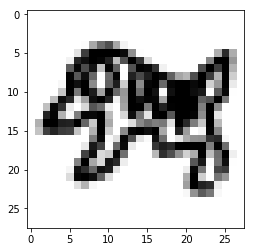

In [16]:
show_object(x_data[0])

# Training the network

In [17]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2 )

img_rows = 28
img_cols = 28
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (400000, 28, 28, 1)
400000 train samples
100000 test samples


In [18]:
# convert class vectors to binary class matrices
num_classes = 100
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [25]:

Inp = Input(shape=input_shape,name = 'Input_layer')

#ConvBlock 01
conv01 = Conv2D(32, (3, 3), padding='same',activation = 'relu', input_shape=Inp.shape,name = 'Conv01_layer')(Inp)
conv02 = Conv2D(32, (3, 3),activation = 'relu',name = 'Conv02_layer')(conv01)
maxpool_01 = MaxPooling2D(pool_size=(2, 2),name = 'MaxPool01_layer')(conv02)
drop01 = BatchNormalization()(maxpool_01)
#drop01 = Dropout(0.25,name = 'Dropout01_layer')(drop01)

#Convblock 02
conv03 = Conv2D(64, (3, 3), padding='same',activation = 'relu',name = 'Conv03_layer')(drop01)
conv04 = Conv2D(64, (3, 3),activation = 'relu',name = 'Conv04_layer')(conv03)
maxpool_02 = MaxPooling2D(pool_size=(2, 2),name = 'MaxPool02_layer')(conv04)
drop02 = BatchNormalization()(maxpool_02)
drop02 = Dropout(0.25,name = 'Dropout02_layer')(drop02)

#Convblock 03
conv05 = Conv2D(64, (3, 3), padding='same',activation = 'relu',name = 'Conv05_layer')(drop02)
conv06 = Conv2D(32, (3, 3),activation = 'relu',name = 'Conv06_layer')(conv05)
maxpool_03 = MaxPooling2D(pool_size=(2, 2),name = 'MaxPool03_layer')(conv06)
drop03 = BatchNormalization()(maxpool_03)
drop03 = Dropout(0.25,name = 'Dropout03_layer')(drop03)

# Fully Connected Dense block
x = Flatten(name = 'Flatten_layer')(drop03)
x = Dense(512, activation='relu',name = 'Dense01_layer')(x)
x = BatchNormalization()(x)
x = Dropout(0.5,name = 'Dropout04_layer')(x)
logits_layer = Dense(num_classes, name= 'logits_layer')(x)
output = Activation('softmax',name = 'Sofftmax_layer')(logits_layer)

In [26]:
model = Model(Inp,output)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_layer (InputLayer)     (None, 28, 28, 1)         0         
_________________________________________________________________
Conv01_layer (Conv2D)        (None, 28, 28, 32)        320       
_________________________________________________________________
Conv02_layer (Conv2D)        (None, 26, 26, 32)        9248      
_________________________________________________________________
MaxPool01_layer (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 13, 13, 32)        128       
_________________________________________________________________
Conv03_layer (Conv2D)        (None, 13, 13, 64)        18496     
_________________________________________________________________
Conv04_layer (Conv2D)        (None, 11, 11, 64)        36928     
__________

In [27]:
#opt = keras.optimizers.rmsprop()
opt = keras.optimizers.Adadelta()
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=opt,
              metrics=['accuracy'])

In [30]:
batch_size = 256
epochs = 10

In [ ]:
hist = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

Train on 400000 samples, validate on 100000 samples
Epoch 1/10
  3584/400000 [..............................] - ETA: 1691s - loss: 5.8787 - acc: 0.0112